In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import binom

In [2]:
def gini_true(y_true, y_score, positive='lower'):
    ascending = (positive == 'lower')
    df = pd.DataFrame({'y_true': y_true, 'y_score': y_score})
    df = df.sort_values('y_score', ascending=ascending).reset_index(drop=True)
    n = len(df)
    df['cum_bad'] = df['y_true'].cumsum() / df['y_true'].sum()
    df['X'] = (np.arange(1, n+1)) / n
    X = [0] + df['X'].tolist()
    Y = [0] + df['cum_bad'].tolist()
    sum_term = sum((Y[i] + Y[i-1]) * (X[i] - X[i-1]) for i in range(1, len(X)))
    DR = df['y_true'].sum() / n
    gini = (sum_term - 1) / (1 - DR)
    return -gini

In [4]:
def check_monotonicity(data, feature, target):
    grouped = data.groupby(feature)[target].mean().reset_index()
    diffs = grouped[target].diff().dropna()
    signs = np.sign(diffs)
    return (signs.nunique() == 1)

In [5]:
train_woe = pd.read_csv("train_woe.csv")
val_woe = pd.read_csv("val_woe.csv")
target = 'def'

In [6]:
train_woe['score'] = (0.668511 * train_woe['dti_woe'] +
                      0.435011 * train_woe['term_woe'] +
                      0.835634 * train_woe['sub_grade_woe'])
val_woe['score'] = (0.668511 * val_woe['dti_woe'] +
                    0.435011 * val_woe['term_woe'] +
                    0.835634 * val_woe['sub_grade_woe'])

factors = ['dti_woe', 'term_woe', 'sub_grade_woe']

### Тест 1: Эффективность ранжирования всей модели

In [42]:
gini_train = gini_true(train_woe[target], train_woe['score'])
gini_val = gini_true(val_woe[target], val_woe['score'])
print(f"\nGini TRAIN = {gini_train:.4f}, Gini VAL = {gini_val:.4f}")

if gini_val >= 0.35:
    print("🟢 Отличная эффективность модели.")
elif gini_val >= 0.25:
    print("🟡 Средняя эффективность модели.")
else:
    print("🔴 Плохая эффективность модели.")


Gini TRAIN = 0.3421, Gini VAL = 0.3335
🟡 Средняя эффективность модели.


Коэффициент Джини составляет 33%. Ранжирующая способность модели находится на среднем уровне. Модель пригодна для использования.

### Тест 2: Эффективность ранжирования факторов


Gini по факторам:
         feature      gini
0        dti_woe  0.149579
1       term_woe  0.125615
2  sub_grade_woe  0.322291


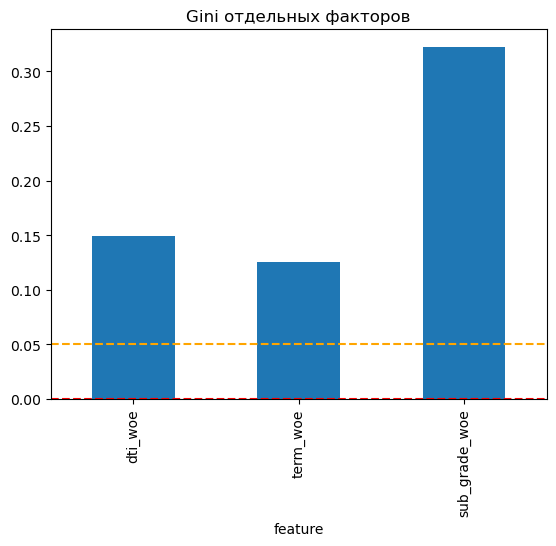

In [43]:
gini_factors = {f: gini_true(val_woe[target], val_woe[f]) for f in factors}
gini_factors_df = pd.DataFrame(list(gini_factors.items()), columns=['feature', 'gini'])

print("\nGini по факторам:")
print(gini_factors_df)

gini_factors_df.plot(kind='bar', x='feature', y='gini', legend=False)
plt.title('Gini отдельных факторов')
plt.axhline(y=0.05, color='orange', linestyle='--')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

Все факторы, вошедшие в модель (dti_woe, term_woe, sub_grade_woe), демонстрируют коэффициенты Джини выше 5%, что соответствует хорошей способности к ранжированию.

### Тест 3: Анализ вклада факторов

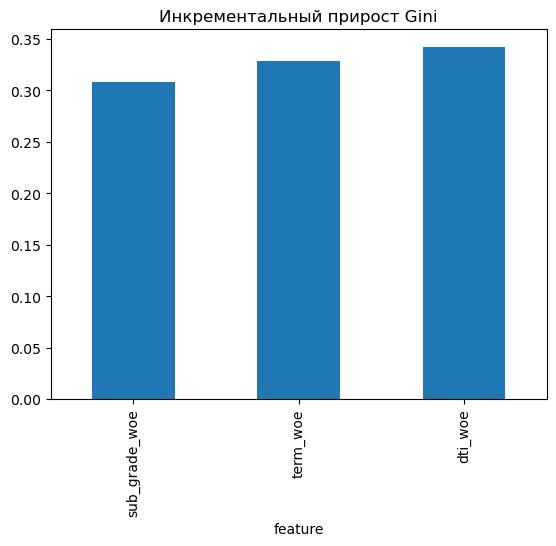

In [ ]:
def incremental_gini(train_data, factors, target):
    results = []
    current_features = []
    for f in sorted(factors, key=lambda x: gini_true(train_data[target], train_data[x]), reverse=True):
        current_features.append(f)
        model = LogisticRegression(solver='liblinear').fit(train_data[current_features], train_data[target])
        score = model.predict_proba(train_data[current_features])[:, 1]
        gini = gini_true(train_data[target], score)
        results.append((f, gini))
    return pd.DataFrame(results, columns=['feature', 'gini'])

incremental_results = incremental_gini(train_woe, factors, target)
incremental_results.plot(kind='bar', x='feature', y='gini', legend=False)
plt.title('Инкрементальный прирост Gini')
plt.show()

При последовательном добавлении факторов наблюдается стабильный прирост коэффициента Джини. Каждый фактор вносит значимый вклад в итоговую модель. Выраженной избыточности признаков не выявлено.


### Тест 4: Динамика Gini

C:\Users\azerb\AppData\Local\Temp\ipykernel_13508\2683728487.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gini_month_train = train_woe.groupby('month').apply(lambda x: gini_true(x[target], x['score']))
C:\Users\azerb\AppData\Local\Temp\ipykernel_13508\2683728487.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gini_month_val = val_woe.groupby('month').apply(lambda x: gini_true(x[target], x['score'

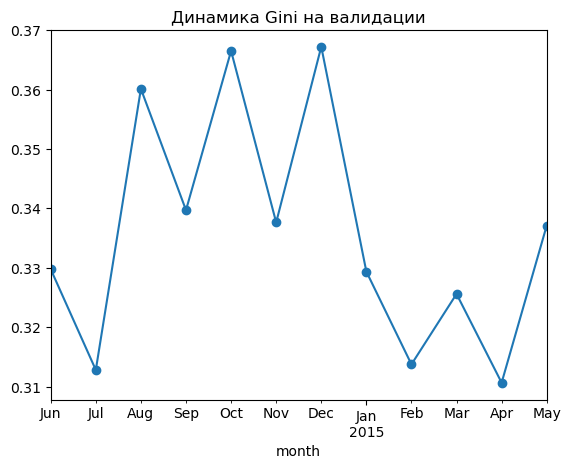

In [ ]:
train_woe['issue_d'] = pd.to_datetime(train_woe['issue_d'])
val_woe['issue_d'] = pd.to_datetime(val_woe['issue_d'])
train_woe['month'] = train_woe['issue_d'].dt.to_period('M')
val_woe['month'] = val_woe['issue_d'].dt.to_period('M')

gini_month_train = train_woe.groupby('month').apply(lambda x: gini_true(x[target], x['score']))
gini_month_val = val_woe.groupby('month').apply(lambda x: gini_true(x[target], x['score']))

gini_month_val.plot(marker='o')
plt.title('Динамика Gini на валидации')
plt.show()

Нет резких просадок Джини ниже критических уровней (например, ниже 0.25).

Общая динамика без явного ухудшения тренда.

### Тест 5: Монотонность WOE

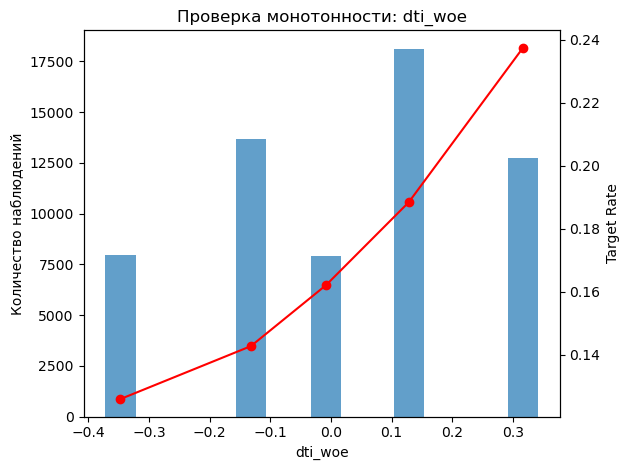

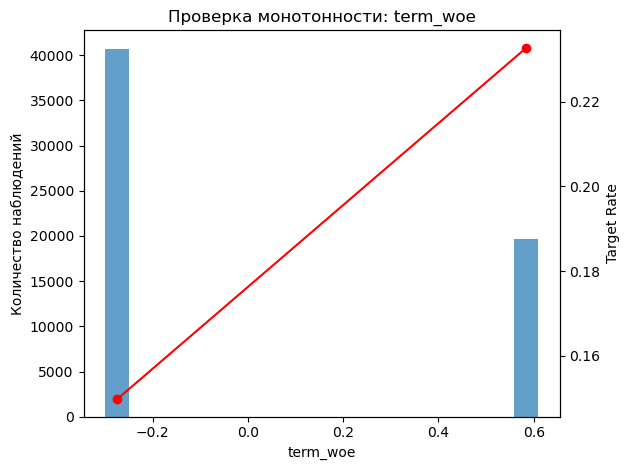

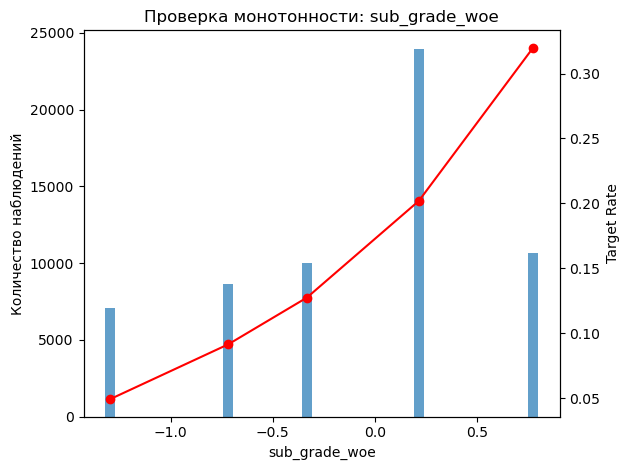

         feature  bad_steps  share_bad color
0        dti_woe          4      0.868     🔴
1       term_woe          1      0.325     🔴
2  sub_grade_woe          4      0.882     🔴


In [44]:
def check_monotonicity_full(data, features, target):
    results = []

    for feature in features:
        df = data[[feature, target]].copy()
        df_grouped = df.groupby(feature).agg(
            events=(target, 'sum'),
            total=(target, 'count')
        ).reset_index()
        df_grouped['TR'] = df_grouped['events'] / df_grouped['total']
        
        fig, ax1 = plt.subplots()

        ax1.bar(df_grouped[feature], df_grouped['total'], width=0.05, alpha=0.7, label='Частота наблюдений')
        ax2 = ax1.twinx()
        ax2.plot(df_grouped[feature], df_grouped['TR'], color='red', marker='o', label='Уровень дефолта')
        
        ax1.set_xlabel(f'{feature}')
        ax1.set_ylabel('Количество наблюдений')
        ax2.set_ylabel('Target Rate')
        plt.title(f'Проверка монотонности: {feature}')
        fig.tight_layout()
        plt.show()

        # Проверка монотонности
        diffs = df_grouped['TR'].diff().dropna()
        rel_diffs = (diffs / df_grouped['TR'].shift(1).dropna()).abs()

        # Где нарушена монотонность (>10%)
        bad_steps = rel_diffs[rel_diffs >= 0.1]
        bad_buckets = len(bad_steps)

        # Считаем долю наблюдений в нарушенных бакетах
        bad_bucket_idx = bad_steps.index
        if len(bad_bucket_idx) > 0:
            bad_total = df_grouped.loc[bad_bucket_idx, 'total'].sum()
        else:
            bad_total = 0
        share_bad = bad_total / df_grouped['total'].sum()

        #  светофор
        if bad_steps.shape[0] > 0 and share_bad > 0.1:
            color = '🔴'
        elif (bad_steps.shape[0] > 0 and share_bad <= 0.1) or (bad_steps.shape[0] == 0 and share_bad > 0.1):
            color = '🟡'
        else:
            color = '🟢'
        
        results.append({
            'feature': feature,
            'bad_steps': bad_steps.shape[0],
            'share_bad': round(share_bad, 3),
            'color': color
        })

    return pd.DataFrame(results)

features = ['dti_woe', 'term_woe', 'sub_grade_woe']
monotonicity_results = check_monotonicity_full(val_woe, features, target='def')
print(monotonicity_results)


Поскольку более 20% факторов получили красный цвет, итоговый результат теста — 🔴 красный.

### Тест 6: Сравнение прогнозного и фактического TR

In [ ]:
# Перевод скор-балла в вероятности дефолта
val_woe['pd_pred'] = 1 / (1 + np.exp(-val_woe['score']))

# Средние значения
avg_pred = val_woe['pd_pred'].mean()
avg_actual = val_woe['def'].mean()

# Стандартное отклонение для доверительных интервалов
std_pred = val_woe['pd_pred'].std()
n = len(val_woe)

# Доверительные интервалы
conf_int_95 = st.norm.interval(0.95, loc=avg_pred, scale=std_pred/np.sqrt(n))
conf_int_99 = st.norm.interval(0.99, loc=avg_pred, scale=std_pred/np.sqrt(n))

print(f"Фактический TR: {avg_actual:.4f}")
print(f"Прогнозный TR: {avg_pred:.4f}")
print(f"95% доверительный интервал: {conf_int_95}")
print(f"99% доверительный интервал: {conf_int_99}")


Фактический TR: 0.1767
Прогнозный TR: 0.4897
95% доверительный интервал: (0.4884577084834223, 0.4909145832040237)
99% доверительный интервал: (0.4880717054891063, 0.4913005861983397)

Абсолютная ошибка прогноза TR: 177.07%

Итоговый результат теста на точность прогноза TR: 🔴 Красный


Фактический TR не попадает в 95% доверительный интервал прогнозной вероятности.

Результат теста: 🔴 красный.

### Тест 7: Сравнение Gini модели (train vs val)


Снижение Gini: 0.0086 абсолютное, 2.51% относительное
Результат теста: 🟢 Зеленый


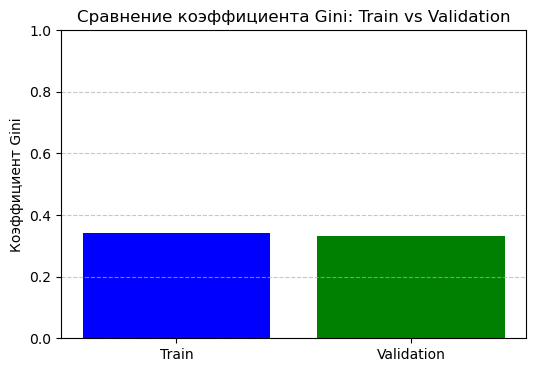

In [ ]:
gini_delta = gini_train - gini_val
gini_relative = gini_delta / gini_train * 100
print(f"\nСнижение Gini: {gini_delta:.4f} абсолютное, {gini_relative:.2f}% относительное")

if gini_delta > 0.05 and gini_relative > 20:
    color = "🔴 Красный"
elif gini_delta > 0.03 and gini_relative > 15:
    color = "🟡 Желтый"
else:
    color = "🟢 Зеленый"

print(f"Результат теста: {color}")

    
plt.figure(figsize=(6, 4))
plt.bar(['Train', 'Validation'], [gini_train, gini_val], color=['blue', 'green'])
plt.title('Сравнение коэффициента Gini: Train vs Validation')
plt.ylabel('Коэффициент Gini')
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


Таким образом, модель демонстрирует стабильность качества ранжирования на новых данных.
Итоговый результат теста — 🟢 Зеленый.

### Тест 8: Сравнение Gini факторов (train vs val)


Результаты по факторам:
         feature  gini_train  gini_val  delta_abs  delta_rel      color
0        dti_woe    0.113377  0.149579   0.036202  31.930970  🟢 Зеленый
1       term_woe    0.181523  0.125615  -0.055907 -30.799042  🔴 Красный
2  sub_grade_woe    0.308158  0.322291   0.014132   4.586009  🟢 Зеленый


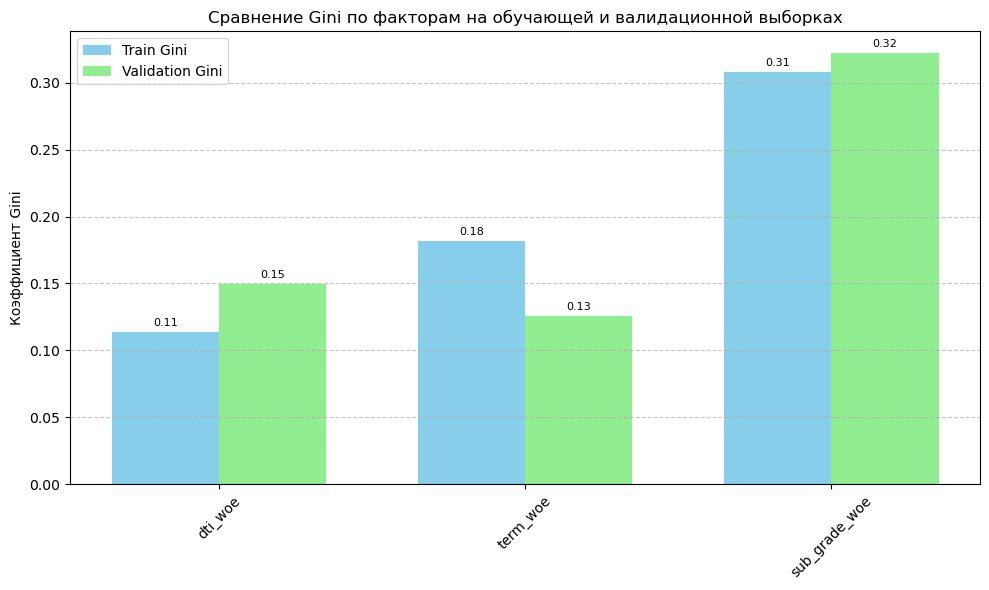

In [ ]:
gini_train_factors = {f: gini_true(train_woe[target], train_woe[f]) for f in factors}
gini_val_factors = {f: gini_true(val_woe[target], val_woe[f]) for f in factors}

factor_changes = pd.DataFrame({
    'feature': factors,
    'gini_train': [gini_train_factors[f] for f in factors],
    'gini_val': [gini_val_factors[f] for f in factors]
})
factor_changes['delta_abs'] = factor_changes['gini_val'] - factor_changes['gini_train']
factor_changes['delta_rel'] = (factor_changes['delta_abs'] / factor_changes['gini_train']) * 100

# светофор
def assign_factor_color(row):
    if row['delta_abs'] < -0.05 and row['delta_rel'] < -20:
        return '🔴 Красный'
    elif row['delta_abs'] < -0.03 and row['delta_rel'] < -15:
        return '🟡 Желтый'
    else:
        return '🟢 Зеленый'

# Применяем к датафрейму
factor_changes['color'] = factor_changes.apply(assign_factor_color, axis=1)

print("\nРезультаты по факторам:")
print(factor_changes[['feature', 'gini_train', 'gini_val', 'delta_abs', 'delta_rel', 'color']])

x = np.arange(len(factor_changes))  # индексы факторов
width = 0.35  # ширина столбиков

fig, ax = plt.subplots(figsize=(10, 6))

# Столбики для Gini на Train
rects1 = ax.bar(x - width/2, factor_changes['gini_train'], width, label='Train Gini', color='skyblue')

# Столбики для Gini на Validation
rects2 = ax.bar(x + width/2, factor_changes['gini_val'], width, label='Validation Gini', color='lightgreen')

ax.set_ylabel('Коэффициент Gini')
ax.set_title('Сравнение Gini по факторам на обучающей и валидационной выборках')
ax.set_xticks(x)
ax.set_xticklabels(factor_changes['feature'], rotation=45)
ax.legend()

ax.grid(axis='y', linestyle='--', alpha=0.7)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # смещение
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


Поскольку среди факторов имеется хотя бы один "красный" результат, итоговый результат теста — 🔴 Красный.

### Тест 9: PSI по факторам

In [3]:
def calculate_psi(expected, actual, buckets=10, eps=1e-6):
    breakpoints = np.percentile(expected, np.linspace(0, 100, buckets + 1))
    expected_percents = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    expected_percents = np.clip(expected_percents, eps, None)
    actual_percents = np.clip(actual_percents, eps, None)
    psi_value = np.sum((expected_percents - actual_percents) * np.log(expected_percents / actual_percents))
    return psi_value

In [ ]:
psi_factors = {f: calculate_psi(train_woe[f], val_woe[f]) for f in factors}
print(pd.DataFrame(list(psi_factors.items()), columns=['feature', 'psi']))

         feature       psi
0        dti_woe  0.056140
1       term_woe  0.019577
2  sub_grade_woe  0.012964


In [47]:
psi_results = pd.DataFrame({
    'feature': ['dti_woe', 'term_woe', 'sub_grade_woe'],
    'psi': [0.056140, 0.019577, 0.012964]
})

# светофор для PSI
def assign_psi_color(psi_value):
    if psi_value >= 0.20:
        return '🔴 Красный'
    elif psi_value >= 0.10:
        return '🟡 Желтый'
    else:
        return '🟢 Зеленый'

psi_results['color'] = psi_results['psi'].apply(assign_psi_color)
print("\nРезультаты теста 9 (Стабильность распределения по факторам):")
display(psi_results)



Результаты теста 9 (Стабильность распределения по факторам):


,feature,psi,color
0,dti_woe,0.056140,🟢 Зеленый
1,term_woe,0.019577,🟢 Зеленый
2,sub_grade_woe,0.012964,🟢 Зеленый


Так как все факторы зеленые, итоговый результат теста на стабильность PSI: 🟢 Зеленый

### Тест 10: Мультиколлинеарность VIF


Результаты расчета VIF факторов на валидационной выборке:


,feature,VIF,color
1,dti_woe,1.036470,🟢 Зеленый
2,term_woe,1.201072,🟢 Зеленый
3,sub_grade_woe,1.232868,🟢 Зеленый


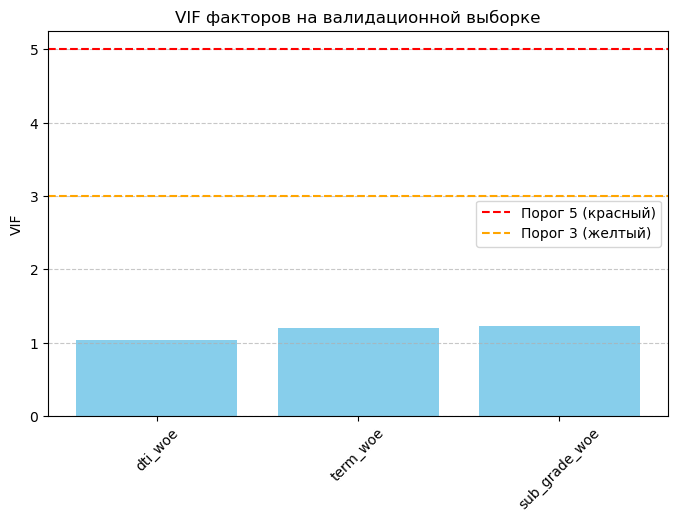

In [48]:
X_val_vif = sm.add_constant(val_woe[factors])

vif_data_val = pd.DataFrame()
vif_data_val['feature'] = X_val_vif.columns
vif_data_val['VIF'] = [variance_inflation_factor(X_val_vif.values, i) for i in range(X_val_vif.shape[1])]

vif_data_val = vif_data_val[vif_data_val['feature'] != 'const']

# Светофор для VIF
def assign_vif_color(vif_value):
    if vif_value > 5:
        return '🔴 Красный'
    elif vif_value > 3:
        return '🟡 Желтый'
    else:
        return '🟢 Зеленый'

vif_data_val['color'] = vif_data_val['VIF'].apply(assign_vif_color)

print("\nРезультаты расчета VIF факторов на валидационной выборке:")
display(vif_data_val)

plt.figure(figsize=(8, 5))
plt.bar(vif_data_val['feature'], vif_data_val['VIF'], color='skyblue')
plt.axhline(5, color='red', linestyle='--', label='Порог 5 (красный)')
plt.axhline(3, color='orange', linestyle='--', label='Порог 3 (желтый)')
plt.ylabel('VIF')
plt.title('VIF факторов на валидационной выборке')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

Итоговый результат теста на мультиколлинеарность: 🟢 Зеленый